In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("nyc311_1m_clean.csv")

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

In [4]:
df_temp = df.copy()
df_temp["created_date"] = pd.to_datetime(df_temp["created_date"])

daily = df_temp.groupby(df_temp["created_date"].dt.date).size()


In [5]:
# Burst Detection in Complaint Time Series
daily = daily.sort_index()
ts = daily

rolling_mean = ts.rolling(window=7).mean()
rolling_std = ts.rolling(window=7).std()

threshold = rolling_mean + 1.4 * rolling_std

bursts = ts[ts > threshold]

print("Detected spikes in complaint activity:")
print(bursts)

Detected spikes in complaint activity:
created_date
2025-08-23     9130
2025-08-28     9378
2025-09-22    11198
2025-10-13    11142
2025-10-16    12420
2025-10-27    12169
dtype: int64


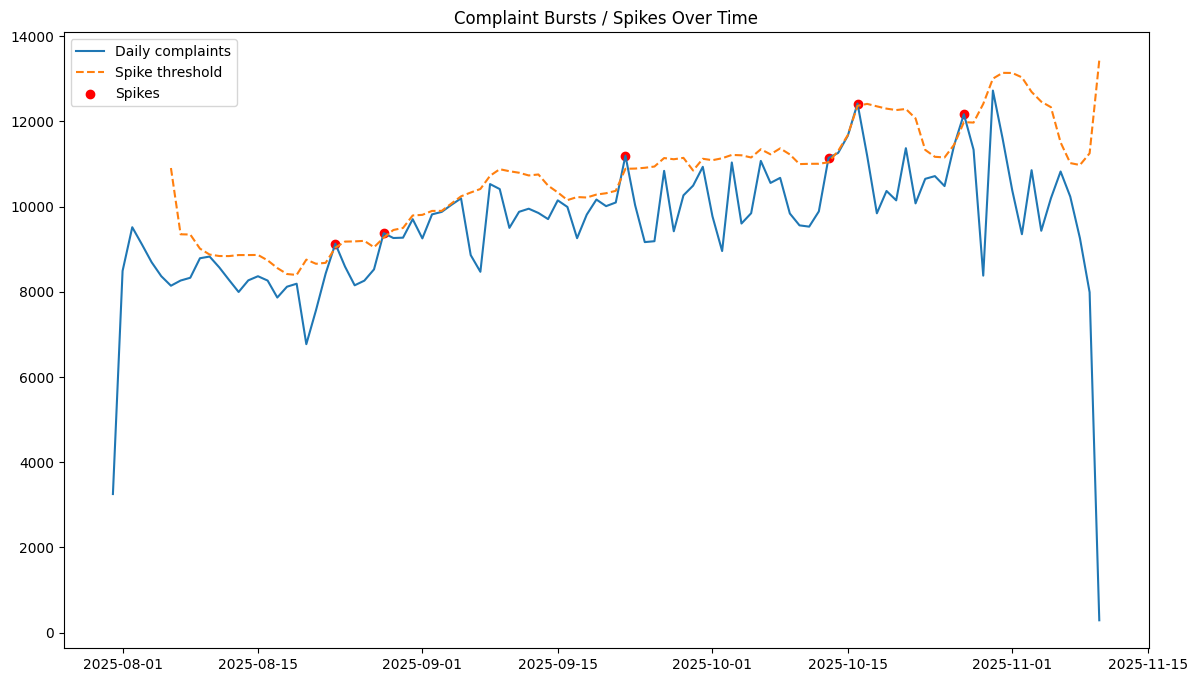

In [6]:
plt.figure(figsize=(14,8))
plt.plot(ts.index, ts.values, label="Daily complaints")
plt.plot(threshold.index, threshold.values, label="Spike threshold", linestyle="--")
plt.scatter(bursts.index, bursts.values, color="red", label="Spikes")
plt.legend()
plt.title("Complaint Bursts / Spikes Over Time")
plt.show()


In [7]:
# Analyzing Spikes by Complaint Type
df_temp["date"] = df_temp["created_date"].dt.date

complaint_daily = df_temp.groupby(["complaint_type", "date"]).size().reset_index(name="count")

def detect_spikes_for_type(ctype):
    sub = complaint_daily[complaint_daily["complaint_type"] == ctype]
    ts = sub.set_index("date")["count"].sort_index()

    rolling_mean = ts.rolling(window=7).mean()
    rolling_std = ts.rolling(window=7).std()
    threshold = rolling_mean + 1.4 * rolling_std
    
    bursts = ts[ts > threshold]
    return bursts

print(detect_spikes_for_type("Rodent"))


date
2025-08-21    156
2025-09-03    143
2025-10-22     86
2025-11-04     68
Name: count, dtype: int64


In [8]:
df["created_date"] = pd.to_datetime(df["created_date"])

daily = (
    df.groupby([pd.Grouper(key="created_date", freq="D"), "complaint_type"])
      .size()
      .reset_index(name="count")
)

daily.head(10)

,created_date,complaint_type,count
0,2025-07-31,Abandoned Vehicle,65
1,2025-07-31,Air Quality,7
2,2025-07-31,Animal in a Park,2
3,2025-07-31,Animal-Abuse,20
4,2025-07-31,Asbestos,1
5,2025-07-31,BEST/Site Safety,1
6,2025-07-31,Blocked Driveway,176
7,2025-07-31,Boilers,2
8,2025-07-31,Broken Parking Meter,2
9,2025-07-31,Building/Use,34


In [9]:
# Burst Detection for Each Complaint Type
WINDOW = 7
Z_THRESHOLD = 1.4

daily = daily.sort_values("created_date")

daily["rolling_mean"] = (
    daily.groupby("complaint_type")["count"]
         .transform(lambda x: x.rolling(WINDOW, min_periods=7).mean())
)

daily["rolling_std"] = (
    daily.groupby("complaint_type")["count"]
         .transform(lambda x: x.rolling(WINDOW, min_periods=7).std())
)

daily["z_score"] = (daily["count"] - daily["rolling_mean"]) / daily["rolling_std"]

daily["anomaly"] = daily["z_score"] > Z_THRESHOLD

daily_anomalies = daily[daily["anomaly"] == True]
daily_anomalies.head(20)


,created_date,complaint_type,count,rolling_mean,rolling_std,z_score,anomaly
690,2025-08-06,Bus Stop Shelter Complaint,7,3.714286,2.138090,1.536752,True
724,2025-08-06,Illegal Posting,30,10.142857,9.668309,2.053838,True
869,2025-08-07,Outdoor Dining,18,12.857143,3.287784,1.564232,True
871,2025-08-07,Panhandling,54,35.857143,9.957051,1.822112,True
852,2025-08-07,Lot Condition,13,7.571429,2.935821,1.849081,True
907,2025-08-07,Water Quality,8,4.000000,2.236068,1.788854,True
891,2025-08-07,Street Sign - Dangling,15,7.142857,4.059087,1.935692,True
811,2025-08-07,Curb Condition,39,20.571429,9.589180,1.921809,True
808,2025-08-07,Construction Lead Dust,4,1.857143,1.069045,2.004459,True
800,2025-08-07,Bike/Roller/Skate Chronic,12,8.714286,2.288689,1.435632,True


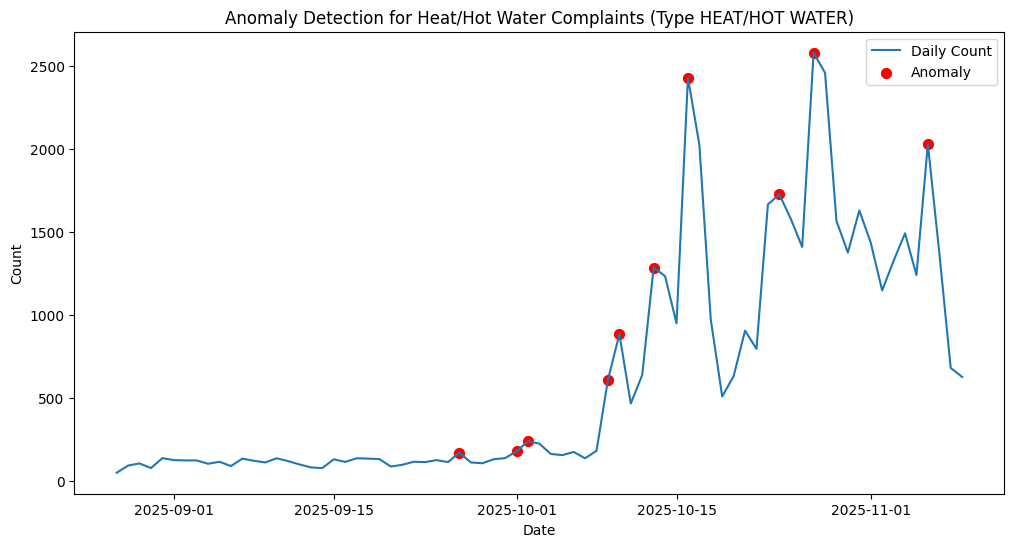

In [10]:
# Visualizing Anomalies for a Specific Complaint Type
complaint = "HEAT/HOT WATER"

subset = daily[daily["complaint_type"] == complaint]

plt.figure(figsize=(12,6))
plt.plot(subset["created_date"], subset["count"], label="Daily Count")
plt.scatter(
    subset[subset["anomaly"] == True]["created_date"],
    subset[subset["anomaly"] == True]["count"],
    marker="o", s=50, color="red", label="Anomaly"
)
plt.title(f"Anomaly Detection for Heat/Hot Water Complaints (Type {complaint})")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.show()
